In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import shap
from causalimpact import CausalImpact
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Global variable for the dataframe
global_df = None
date_col = None
target_col = None

# Define a simpler file upload function
def upload_and_process_file(b):
    global global_df
    clear_output()
    
    upload = widgets.FileUpload(
        accept='.csv', 
        multiple=False,
        description='Select a CSV file:'
    )
    display(upload)
    
    def on_upload_change(change):
        global global_df
        if not upload.value:
            return
            
        try:
            # Get the filename
            filename = list(upload.value)[0]
            content = filename['content']
            
            # Read the CSV
            global_df = pd.read_csv(io.BytesIO(content),parse_dates=True)
            
            clear_output()
            print(f"✅ File loaded: {filename['name']}")
            print(f"Shape: {global_df.shape}")
            display(global_df.head())
            
            # Create and display analysis widgets
            setup_analysis_widgets()
            
        except Exception as e:
            clear_output()
            print(f"Error loading file: {str(e)}")
            display(upload)
    
    upload.observe(on_upload_change, names='value')

# Setup analysis widgets after file is loaded
def setup_analysis_widgets():
    global global_df
    
    if global_df is None:
        print("No data loaded. Please upload a file first.")
        return
    
    # Create column selection dropdowns
    date_dropdown = widgets.Dropdown(
        options=['Select'] + list(global_df.columns),
        description='Date Column:',
        style={'description_width': 'initial'}
    )
    
    target_dropdown = widgets.Dropdown(
        options=['Select'] + list(global_df.columns),
        description='Target Column:',
        style={'description_width': 'initial'}
    )
    
    # Run analysis button
    run_button = widgets.Button(
        description='Run Analysis',
        button_style='success'
    )
    
    output = widgets.Output()
    
    def on_run_click(b):
        date_col = date_dropdown.value
        target_col = target_dropdown.value
        
        if date_col == 'Select' or target_col == 'Select':
            with output:
                clear_output()
                print("Please select both date and target columns.")
            return
        
        with output:
            clear_output()
            run_analysis(date_col, target_col)
    
    run_button.on_click(on_run_click)
    
    # Display all widgets
    display(widgets.HTML("<h3>Select columns for analysis:</h3>"))
    display(date_dropdown)
    display(target_dropdown)
    display(run_button)
    display(output)

def perform_basic_eda(df, date_col, target_col):
    """Performs basic EDA on the sales data."""
    print("\n===== Basic Exploratory Data Analysis =====")
    
    try:
        # Statistics
        print(f"\nSummary Statistics for {target_col}:")
        display(df[target_col].describe())
            # Check for missing values
        
        missing_values = df.isnull().sum()
        print("\nMissing Values:")
        print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found")
        
        # Monthly trend if possible
        try:
            df.set_index(date_col, inplace=True)
            monthly = df[target_col].resample('ME').mean()
            
            if len(monthly) > 1:
                print("\nMonthly averages:")
                display(monthly.head())
                
                plt.figure(figsize=(10, 5))
                monthly.plot()
                plt.title(f'Monthly Average of {target_col}')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Could not generate monthly trend: {str(e)}")
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

    
    # Distribution of sales
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=True)
    plt.title(f'Distribution of {target_col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[target_col])
    plt.title(f'Boxplot of {target_col}')
    plt.tight_layout()
    plt.show()
    
    return df

def add_time_features(df):
    """Add time-based features to the dataset."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)
    
    print("\nAdded time-based features to dataset.")
    # return df

def analyze_time_patterns(df, sales_col):
    """Analyzes sales patterns by different time periods."""
    print("\n===== Time-based Sales Patterns =====")
    
    # Set date as index
    df_time = df.copy(deep=True)
    
    # Monthly pattern
    monthly_avg = df_time.groupby(df_time.index.month)[sales_col].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg.index = [months[i-1] for i in monthly_avg.index]
    
    # Day of week pattern
    dow_avg = df_time.groupby(df_time.index.dayofweek)[sales_col].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dow_avg.index = [days[i] for i in dow_avg.index]
    
    # Plots
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
    plt.title('Average Sales by Month')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x=dow_avg.index, y=dow_avg.values)
    plt.title('Average Sales by Day of Week')
    
    # Yearly trend (if multiple years exist)
    if df_time.index.year.nunique() > 1:
        yearly_avg = df_time.groupby(df_time.index.year)[sales_col].mean()
        plt.subplot(2, 2, 3)
        sns.lineplot(x=yearly_avg.index, y=yearly_avg.values, marker='o')
        plt.title('Average Sales by Year')
        plt.xlabel('Year')
    
    # Time heatmap (month vs day of week)
    if len(df) >= 30:  # Ensure enough data
        plt.subplot(2, 2, 4)
        heatmap_data = df.pivot_table(
            index='day_of_week', 
            columns='month', 
            values=sales_col, 
            aggfunc='mean'
        )
        heatmap_data.index = days
        heatmap_data.columns = [months[i-1] for i in heatmap_data.columns]
        sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5)
        plt.title('Sales Heatmap: Day of Week vs Month')
    
    plt.tight_layout()
    plt.show()
    
    # Interactive time analysis with Plotly
    try:
        # Monthly trend over years
        df_time = df.copy(deep=True)
        monthly_data = df_time.groupby([df_time.year, df_time.month])[sales_col].mean().reset_index()
        monthly_data['date'] = pd.to_datetime(monthly_data.year.astype(str) + '-' + monthly_data['month'].astype(str) + '-01')

        fig = px.line(monthly_data, x='date', y=sales_col, title=f'Monthly {sales_col} Trend')
        fig.update_xaxes(title_text='Date')
        fig.update_yaxes(title_text=sales_col)
        fig.show()
    except Exception as e:
        print(f"Couldn't create interactive plot: {e}")

def create_lag_features(df, sales_col, lags=[1, 7, 30]):
    """Creates lag features for time series data."""
    print("\n===== Creating Lag Features =====")
    
    df_sorted = df.copy(deep=True).sort_index().reset_index()
    
    for lag in lags:
        df_sorted[f'lag_{lag}'] = df_sorted[sales_col].shift(lag)
        
        # Also create percentage change features
        df_sorted[f'pct_change_{lag}'] = df_sorted[sales_col].pct_change(periods=lag)
    
    # Create rolling window features
    windows = [7, 14, 30]
    for window in windows:
        if len(df) > window:
            df_sorted[f'rolling_mean_{window}'] = df_sorted[sales_col].rolling(window=window).mean()
            df_sorted[f'rolling_std_{window}'] = df_sorted[sales_col].rolling(window=window).std()
            
            # Expanding mean - cumulative average up to current point
            df_sorted[f'expanding_mean'] = df_sorted[sales_col].expanding().mean()
    
    # Create trend indicator
    if len(df) >= 3:
        df_sorted['short_trend'] = df_sorted[sales_col].rolling(window=3).apply(
            lambda x: 1 if (x.iloc[2] > x.iloc[0]) else (-1 if (x.iloc[2] < x.iloc[0]) else 0)
        )
    
    # Create seasonality features if enough data (simple fourier terms)
    if len(df) >= 30:
        for period in [6, 12]:
            for order in [1, 2]:
                df_sorted[f'sin_{period}_{order}'] = np.sin(order * 2 * np.pi * df_sorted.index / period)
                df_sorted[f'cos_{period}_{order}'] = np.cos(order * 2 * np.pi * df_sorted.index / period)
    
    # Print created features
    new_features = [col for col in df_sorted.columns if col not in df.columns]
    print(f"Created {len(new_features)} new features: {', '.join(new_features)}")
    
    return df_sorted    
    
def feature_importance_analysis(df, sales_col, date_col):
    """Uses XGBoost and SHAP to analyze feature importance."""
    print("\n===== Feature Importance Analysis =====")
    
    try:
        # Filter numeric columns only
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if date_col in num_cols:
            num_cols.remove(date_col)
        if sales_col in num_cols:
            num_cols.remove(sales_col)
        if 'Customers' in num_cols:
            num_cols.remove('Customers')
        
        # Check if we have enough features and data
        if len(num_cols) < 2:
            print("Not enough numeric features for analysis")
            return df
        
        # Remove rows with NaN (from lag features)
        df_clean = df.dropna().copy()
        if len(df_clean) < len(df) * 0.5:  # If too many rows lost
            print(f"Warning: {len(df) - len(df_clean)} rows dropped due to missing values")
        
        # Prepare training data
        X = df_clean[num_cols]  # Features
        y = df_clean[sales_col]  # Target variable

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train XGBoost model
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Feature importance plot
        plt.figure(figsize=(12, 6))
        xgb.plot_importance(model, max_num_features=20, height=0.5)
        plt.title(f'XGBoost Feature Importance for {sales_col}')
        plt.tight_layout()
        plt.show()
        
        # SHAP values for more detailed feature importance
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test, check_additivity=False)
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, plot_size=(12, 8))
        plt.show()
        
        # Detailed SHAP plots for top features
        top_features = model.feature_importances_.argsort()[-5:][::-1]
        for i in top_features:
            feature_name = X_test.columns[i]
            plt.figure(figsize=(10, 4))
            shap.dependence_plot(feature_name, shap_values.values, X_test, show=False)
            plt.title(f'SHAP Dependence Plot for {feature_name}')
            plt.tight_layout()
            plt.show()
        
        # Store importance in dataframe
        importance_df = pd.DataFrame({
            'Feature': X_test.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10))
        
        # Find the most influential time features
        time_features = [f for f in importance_df['Feature'] if any(x in f for x in ['month', 'day', 'week', 'year', 'is_'])]
        if time_features:
            print("\nMost Important Time Features:")
            for feat in time_features[:5]:
                print(f"- {feat}")
        
        # Find the most influential lag features
        lag_features = [f for f in importance_df['Feature'] if 'lag_' in f or 'rolling_' in f]
        if lag_features:
            print("\nMost Important Lag Features:")
            for feat in lag_features[:5]:
                print(f"- {feat}")

    except Exception as e:
        print(f"Error in feature importance analysis: {e}")
    
    return df

# Separate analysis function
def run_analysis(date_col, target_col):
    global global_df
    
    try:
        # Create a copy to avoid modifying the original
        df = global_df.copy(deep=True)
        # Convert date column to datetime
        df[date_col] = pd.to_datetime(df[date_col])
        
        print(f"Analyzing {target_col} using {date_col} as the date column...")
        
        # 1. Basic EDA
        perform_basic_eda(df, date_col, target_col)
        
        # 2. Time-based analysis
        add_time_features(df, date_col)
        analyze_time_patterns(df, date_col, target_col)
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")

# Start the process
upload_button = widgets.Button(
    description='Load CSV File',
    button_style='primary',
    icon='upload'
)
upload_button.on_click(upload_and_process_file)
display(upload_button)

Button(button_style='primary', description='Load CSV File', icon='upload', style=ButtonStyle())

In [172]:
df_test = pd.read_csv('./data/rossmann-store-sales/train.csv',parse_dates=True,low_memory=False)
df_test_y = pd.read_csv('./data/rossmann-store-sales/test.csv',parse_dates=True,low_memory=False)
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test_y['Date'] = pd.to_datetime(df_test_y['Date'])


===== Basic Exploratory Data Analysis =====

Summary Statistics for Sales:


count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64


Missing Values:
No missing values found

Monthly averages:


Date
2013-01-31    5211.555578
2013-02-28    5494.371397
2013-03-31    5820.349168
2013-04-30    5483.749836
2013-05-31    5364.127383
Freq: ME, Name: Sales, dtype: float64

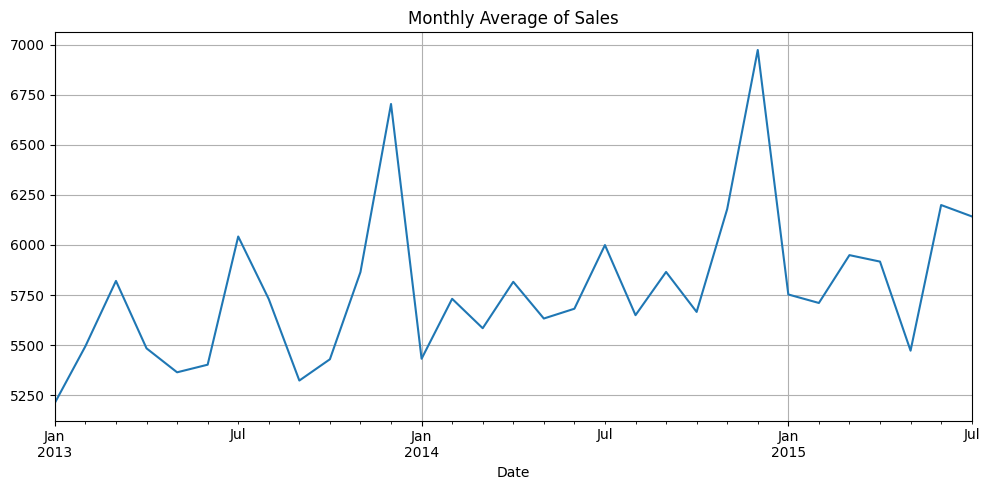

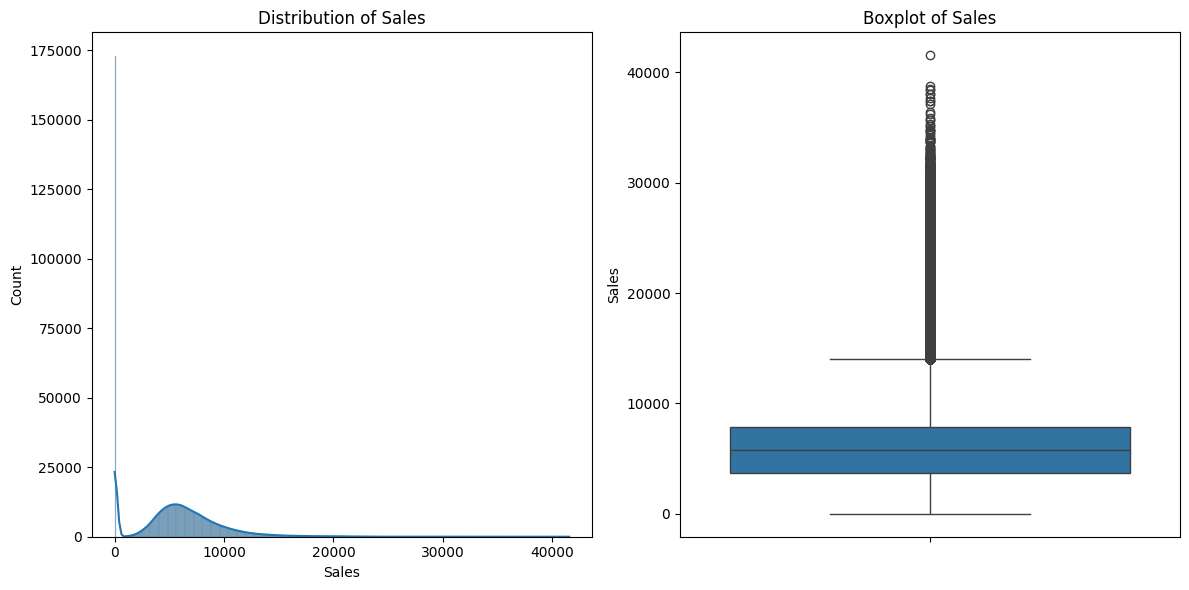


Added time-based features to dataset.


In [ ]:
test_date_col = 'Date'
test_target_col = 'Sales'
perform_basic_eda(df_test, test_date_col, test_target_col)
add_time_features(df_test)


===== Time-based Sales Patterns =====


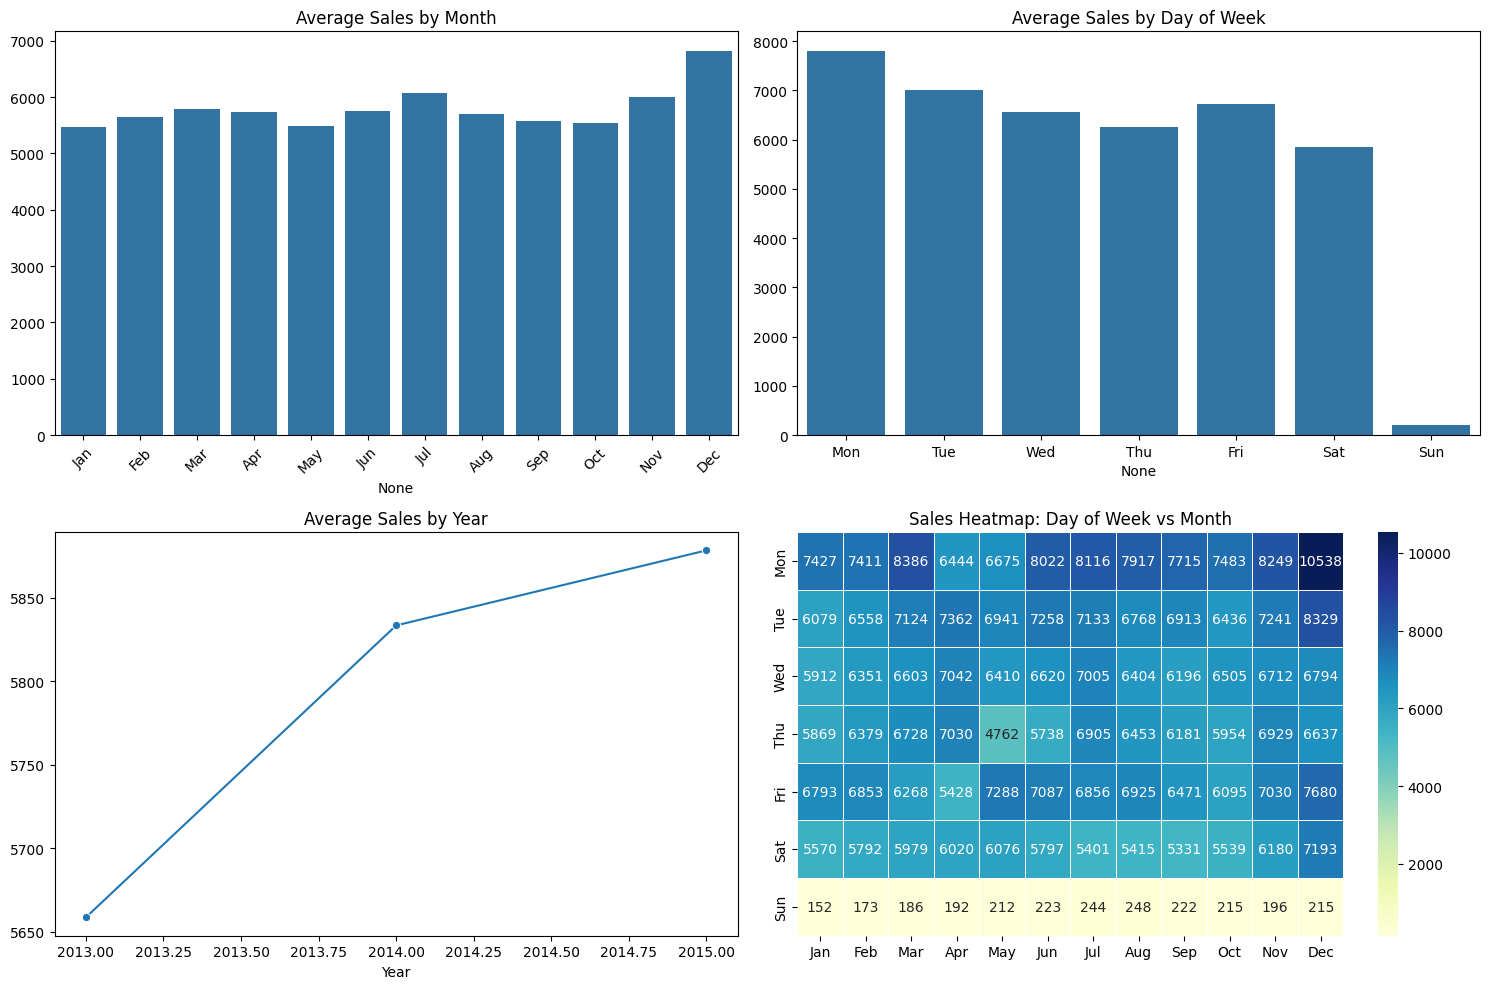

In [156]:
analyze_time_patterns(df_test, test_target_col)

In [160]:
create_lag_features(df_test, test_target_col)


===== Creating Lag Features =====
Created 23 new features: Date, lag_1, pct_change_1, lag_7, pct_change_7, lag_30, pct_change_30, rolling_mean_7, rolling_std_7, expanding_mean, rolling_mean_14, rolling_std_14, rolling_mean_30, rolling_std_30, short_trend, sin_6_1, cos_6_1, sin_6_2, cos_6_2, sin_12_1, cos_12_1, sin_12_2, cos_12_2


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,...,rolling_std_30,short_trend,sin_6_1,cos_6_1,sin_6_2,cos_6_2,sin_12_1,cos_12_1,sin_12_2,cos_12_2
0,2013-01-01,1115,2,0,0,0,0,a,1,2013,...,NaN,NaN,0.000000e+00,1.0,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000e+00,1.0
1,2013-01-01,379,2,0,0,0,0,a,1,2013,...,NaN,NaN,8.660254e-01,0.5,8.660254e-01,-0.5,5.000000e-01,8.660254e-01,8.660254e-01,0.5
2,2013-01-01,378,2,0,0,0,0,a,1,2013,...,NaN,0.0,8.660254e-01,-0.5,-8.660254e-01,-0.5,8.660254e-01,5.000000e-01,8.660254e-01,-0.5
3,2013-01-01,377,2,0,0,0,0,a,1,2013,...,NaN,0.0,1.224647e-16,-1.0,-2.449294e-16,1.0,1.000000e+00,6.123234e-17,1.224647e-16,-1.0
4,2013-01-01,376,2,0,0,0,0,a,1,2013,...,NaN,0.0,-8.660254e-01,-0.5,8.660254e-01,-0.5,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2015-07-31,746,5,9082,638,1,1,0,1,2015,...,3991.989473,1.0,1.763593e-11,1.0,3.527187e-11,1.0,8.817967e-12,1.000000e+00,1.763593e-11,1.0
1017205,2015-07-31,747,5,10708,826,1,1,0,1,2015,...,3967.066974,1.0,8.660254e-01,0.5,8.660254e-01,-0.5,5.000000e-01,8.660254e-01,8.660254e-01,0.5
1017206,2015-07-31,748,5,7481,578,1,1,0,1,2015,...,3964.317101,-1.0,8.660254e-01,-0.5,-8.660254e-01,-0.5,8.660254e-01,5.000000e-01,8.660254e-01,-0.5
1017207,2015-07-31,742,5,10460,1016,1,1,0,1,2015,...,3910.298839,-1.0,1.039061e-10,-1.0,-2.078122e-10,1.0,1.000000e+00,5.195304e-11,1.039061e-10,-1.0



===== Feature Importance Analysis =====


<Figure size 1200x600 with 0 Axes>

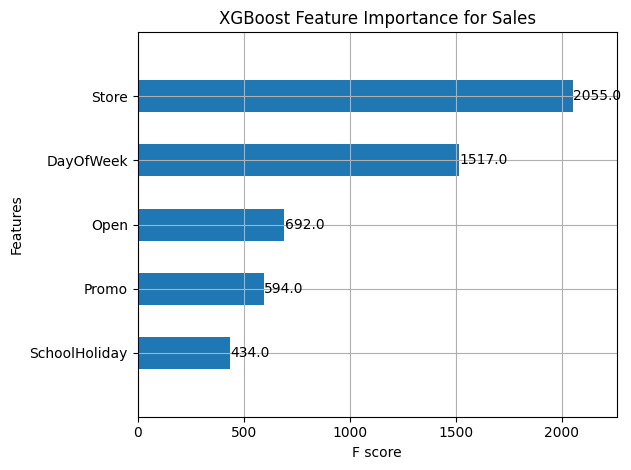

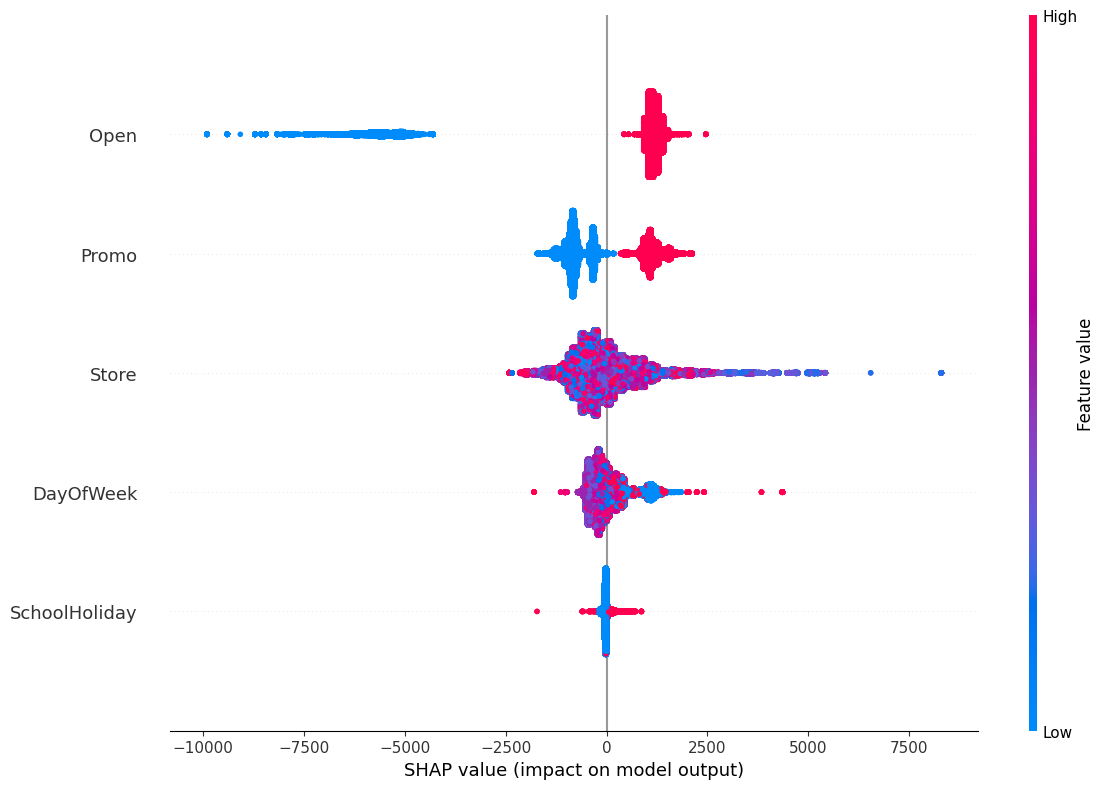

<Figure size 1000x400 with 0 Axes>

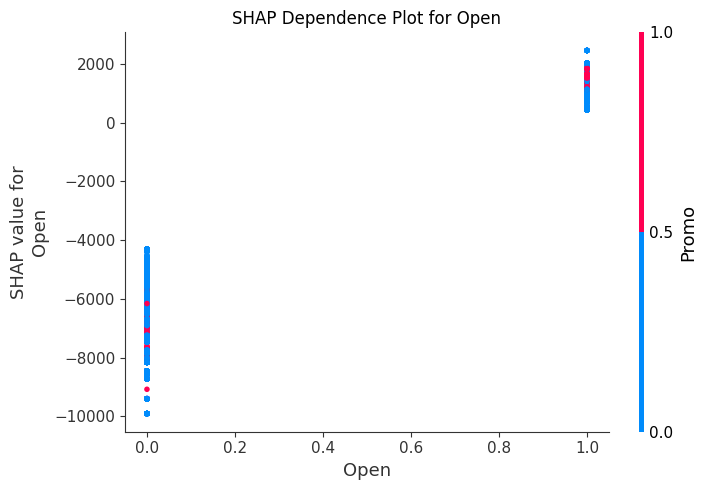

<Figure size 1000x400 with 0 Axes>

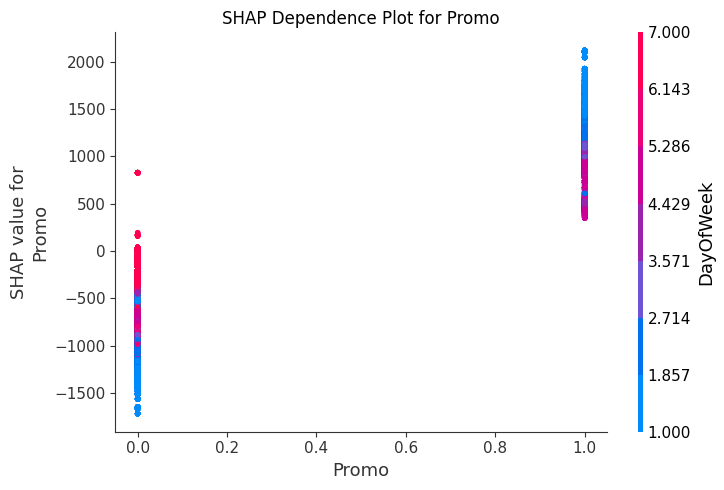

<Figure size 1000x400 with 0 Axes>

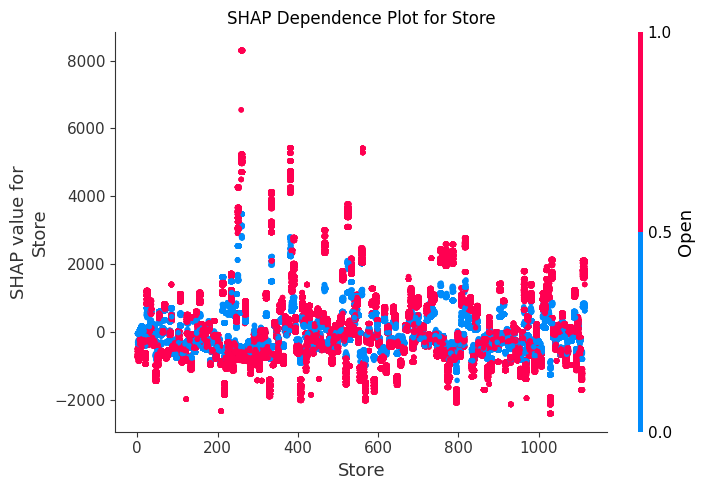

<Figure size 1000x400 with 0 Axes>

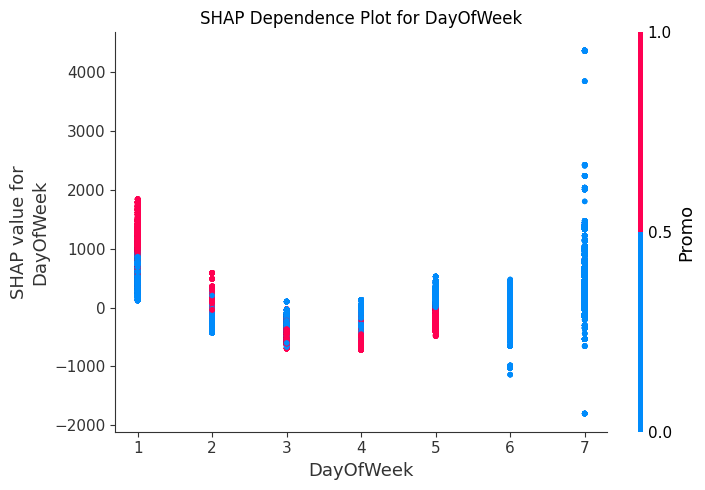

<Figure size 1000x400 with 0 Axes>

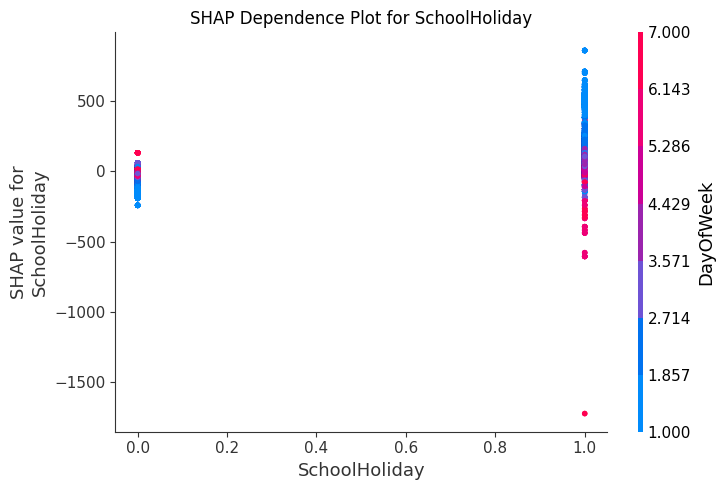


Top 10 Most Important Features:
         Feature  Importance
2           Open    0.786539
3          Promo    0.149175
0          Store    0.042094
1      DayOfWeek    0.019400
4  SchoolHoliday    0.002792

Most Important Time Features:
- SchoolHoliday


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [177]:
feature_importance_analysis(df_test, test_target_col, test_date_col)